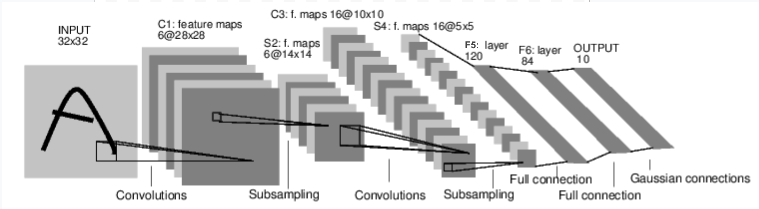

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:

\begin{align}weight = weight - learningRate * gradient\end{align}


Define the network
------------------

Let’s define this network:


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)

2.0.1+cu118


We want to be able to train our model on a hardware accelerator like the GPU or MPS, if available. 

Let’s check to see if ``torch.cuda`` or ``torch.backends.mps`` are available, otherwise we use the CPU.

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


C:\Python311\Lib\site-packages\torch\cuda\__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


**let us examine the component layers of NN**

In [3]:
nn.Module?

Init signature: nn.Module(*args, **kwargs) -> None
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
    must be made before assignment on the child.

:ivar training: Boolean represents whether this module is in training or
                ev

In [4]:
nn.Linear??

Init signature:
nn.Linear(
    in_features: int,
    out_features: int,
    bias: bool = True,
    device=None,
    dtype=None,
) -> None
Source:        
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Att

**Example on ``Linear``:**

In [10]:
input = torch.rand(3,2,4)
print("input:")
print(input)

LinearLayer=nn.Linear(in_features=4, out_features=3, bias=True)

print("Linear:")
print(LinearLayer)

print("LinearLayer weights:")
print(LinearLayer.weight)

print("bias:")
print(LinearLayer.bias)

out = LinearLayer(input)
print(out.size())
print("out:")
print(out)

input:
tensor([[[0.0764, 0.2180, 0.4770, 0.8046],
         [0.5839, 0.4673, 0.2910, 0.3248]],

        [[0.8964, 0.7247, 0.1474, 0.8544],
         [0.3680, 0.8551, 0.4296, 0.7893]],

        [[0.9052, 0.1641, 0.0870, 0.2607],
         [0.1561, 0.9053, 0.6776, 0.0402]]])
Linear:
Linear(in_features=4, out_features=3, bias=True)
LinearLayer weights:
Parameter containing:
tensor([[ 0.3932,  0.1309,  0.0330, -0.3832],
        [-0.2499, -0.3983, -0.1670, -0.0007],
        [ 0.0077, -0.0308,  0.3206,  0.3566]], requires_grad=True)
bias:
Parameter containing:
tensor([-0.1949, -0.3744,  0.0813], requires_grad=True)
torch.Size([3, 2, 3])
out:
tensor([[[-0.4290, -0.5606,  0.5150],
         [-0.0190, -0.7553,  0.2805]],

        [[-0.0702, -0.9123,  0.4178],
         [-0.2266, -0.8793,  0.4770]],

        [[ 0.0854, -0.6807,  0.2041],
         [-0.0081, -0.8872,  0.2862]]], grad_fn=<ViewBackward0>)


In [12]:
nn.Conv2d?

Init signature:
nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[str, int, Tuple[int, int]] = 0,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:

**Example on ``Conv2d``:**

In [15]:
input = torch.rand(1,4,4)
print("input:")
print(input)

convLayer=nn.Conv2d(in_channels=1, out_channels=1, kernel_size = 2, stride=1, bias=True)

print("kernel_size:") 
print(convLayer.kernel_size)

print("convLayer:")
print(convLayer)

print("convLayer weights:")
print(convLayer.weight)

print("bias:")
print(convLayer.bias)

twoD_out = convLayer(input)
print(twoD_out.size())
print("twoD_out:")
print(twoD_out)

input:
tensor([[[0.4816, 0.7650, 0.4085, 0.0731],
         [0.3741, 0.7406, 0.5777, 0.5610],
         [0.1532, 0.5429, 0.7209, 0.2285],
         [0.8654, 0.6508, 0.9986, 0.4156]]])
kernel_size:
(2, 2)
convLayer:
Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1))
convLayer weights:
Parameter containing:
tensor([[[[-0.3251,  0.1477],
          [ 0.0344, -0.0646]]]], requires_grad=True)
bias:
Parameter containing:
tensor([0.4512], requires_grad=True)
torch.Size([1, 3, 3])
twoD_out:
tensor([[[0.3726, 0.2509, 0.3128],
         [0.4091, 0.2678, 0.3562],
         [0.4693, 0.3390, 0.2580]]], grad_fn=<SqueezeBackward1>)


In [28]:
F.max_pool2d??

**Example on ``max_pool2d``:**

In [17]:
x = F.max_pool2d(twoD_out, kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False, return_indices=False)
print(x)

tensor([[[0.4091, 0.3562],
         [0.4693, 0.3562]]], grad_fn=<MaxPool2DWithIndicesBackward0>)


In [9]:
F.relu??

Signature: F.relu(input: torch.Tensor, inplace: bool = False) -> torch.Tensor
Source:   
def relu(input: Tensor, inplace: bool = False) -> Tensor:
    r"""relu(input, inplace=False) -> Tensor

    Applies the rectified linear unit function element-wise. See
    :class:`~torch.nn.ReLU` for more details.
    """
    if has_torch_function_unary(input):
        return handle_torch_function(relu, (input,), input, inplace=inplace)
    if inplace:
        result = torch.relu_(input)
    else:
        result = torch.relu(input)
    return result
File:      c:\python311\lib\site-packages\torch\nn\functional.py
Type:      function

**Example on ``relu``:**

In [19]:
relu = F.relu (twoD_out)
print(relu)

tensor([[[0.3726, 0.2509, 0.3128],
         [0.4091, 0.2678, 0.3562],
         [0.4693, 0.3390, 0.2580]]], grad_fn=<ReluBackward0>)


**``view``: returns the a new tensor with the same data as the self tensor but with different shape**

In [22]:
x= torch.rand(2,4)
print(x.size())

#y = x.view(8)
#y = x.view((8,1))
y = x.view((4,2))
print(x)

print(y)

torch.Size([2, 4])
tensor([[0.8956, 0.1274, 0.1488, 0.6894],
        [0.6333, 0.5112, 0.9269, 0.8875]])
tensor([[0.8956, 0.1274],
        [0.1488, 0.6894],
        [0.6333, 0.5112],
        [0.9269, 0.8875]])


**Example on ``Softmax``:**

In [23]:
softmax = nn.Softmax(dim=1)
print(softmax)
outSoftmax = softmax(twoD_out)
print("outSoftmax:")
print(outSoftmax)

Softmax(dim=1)
outSoftmax:
tensor([[[0.3186, 0.3216, 0.3343],
         [0.3305, 0.3271, 0.3492],
         [0.3509, 0.3513, 0.3165]]], grad_fn=<SoftmaxBackward0>)


**let us build a network using these types of layers:**

In [15]:
#import torch
#import torch.nn as nn
#import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__() 
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)  # first convolutional neywork
        self.conv2 = nn.Conv2d(6, 16, 3)  # sencond convolutional neywork
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension, 16 for channels
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # Max pooling over a (2, 2) window
        
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # If the size is a square you can only specify a single number
        x = x.view(-1, self.num_flat_features(x))
        print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


**You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.**

**The learnable parameters of a model are returned by ``net.parameters()``**

In [16]:
params = list(net.parameters())
#print(params) #printing the weights (elements of all the kernels)
print(len(params))
print(params[0].size())  # conv1's .weight
print(params[6].size())  # .weight

10
torch.Size([6, 1, 3, 3])
torch.Size([84, 120])


**Let's try a random 32x32 input.**

**Note: expected input size of this net (Net) is 32x32. To use this net on
the MNIST dataset, please resize the images from the dataset to 32x32.**

In [17]:
input = torch.randn(1, 1, 32, 32) # creat the input as tensor that contains random variables
print(input)
out = net(input) # pass the 
print(out)

tensor([[[[ 0.1454,  1.3207,  1.5752,  ..., -0.6914,  2.0926,  0.4686],
          [-0.1192, -0.1926, -0.3943,  ...,  1.3754,  0.3149, -0.6377],
          [ 0.6017, -0.0439,  0.9290,  ...,  1.4541, -0.3121,  0.3133],
          ...,
          [ 1.6856,  0.3179, -0.8104,  ...,  0.8880,  0.4201,  0.0586],
          [ 0.4284, -0.5572, -1.2926,  ..., -1.0676,  0.6577,  0.3990],
          [-0.8463, -1.6223, -0.3194,  ...,  1.2127,  0.9200,  0.8838]]]])
torch.Size([1, 576])
tensor([[-0.0235,  0.0400,  0.0093, -0.0664, -0.0281, -0.0014,  0.0952, -0.0886,
         -0.0216, -0.0566]], grad_fn=<AddmmBackward0>)


**The graph of computations that looks like this:**

input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
      -> view -> linear -> relu -> linear -> relu -> linear

**Zero the gradient buffers of all parameters and backprops with random
gradients:**

In [99]:
net.zero_grad()
out.backward(torch.randn(1, 10))

### NOTE: 
`torch.nn` only supports mini-batches. The entire `torch.nn`
    package only supports inputs that are a mini-batch of samples, and not
    a single sample. 
    
For example, `nn.Conv2d` will take in a 4D Tensor of `nSamples x nChannels x Height x Width`.

If you have a single sample, just use `input.unsqueeze(0)` to add a fake batch dimension.
    __________________________________________________________________________________________________

Before proceeding further, let's recap all the classes you’ve seen so far.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Tensor`` operation creates at
     least a single ``Function`` node that connects to functions that
     created a ``Tensor`` and *encodes its history*.

**At this point, we covered:**
  -  Defining a neural network
  -  Processing inputs and calling backward

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

## Loss Function

A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different
[loss functions] (https://pytorch.org/docs/nn.html#loss-functions)  under the
nn package.
A simple loss is: ``nn.MSELoss`` which computes the mean-squared error
between the input and the target.

For example:



In [18]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

torch.Size([1, 576])
tensor(0.7865, grad_fn=<MseLossBackward0>)


Now, if you follow ``loss`` in the backward direction, using its
``.grad_fn`` attribute, you will see a graph of computations that looks
like this:

::

    input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
          -> view -> linear -> relu -> linear -> relu -> linear
          -> MSELoss
          -> loss

So, when we call ``loss.backward()``, the whole graph is differentiated
w.r.t. the loss, and all Tensors in the graph that has ``requires_grad=True``
will have their ``.grad`` Tensor accumulated with the gradient.

For illustration, let us follow a few steps backward:

In [117]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

Backprop
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at conv1's bias
gradients before and after the backward.


In [19]:
print('conv1.bias.grad before zeroing')
print(net.conv1.bias.grad)

net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before zeroing
None
conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0093,  0.0144, -0.0070, -0.0034, -0.0094, -0.0148])


Now, we have seen how to use loss functions.

**Read Later:**

  The neural network package contains various modules and loss functions
  that form the building blocks of deep neural networks. A full list with
  documentation is [here] (https://pytorch.org/docs/nn).

**The only thing left to learn is:**

  - Updating the weights of the network

Update the weights
------------------
The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):

\begin{align}weight = weight - learningRate * gradient\end{align}

We can implement this using simple Python code:


    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
To enable this, we built a small package: ``torch.optim`` that
implements all these methods. Using it is very simple:

In [21]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01) 

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

torch.Size([1, 576])


In [22]:
import torch.optim as optim

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01) 

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

torch.Size([1, 576])


**You have seen how to define neural networks, compute loss and make updates to the weights of the network.
One thing is still missing:**

## Input Data


Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful


**Let us show our training images, for fun!**

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

In [34]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    print("img:")
    print(img)
    npimg = img.numpy()
    print("npimg:")
    print(npimg)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[ 0.1454,  1.3207,  1.5752,  ..., -0.6914,  2.0926,  0.4686],
          [-0.1192, -0.1926, -0.3943,  ...,  1.3754,  0.3149, -0.6377],
          [ 0.6017, -0.0439,  0.9290,  ...,  1.4541, -0.3121,  0.3133],
          ...,
          [ 1.6856,  0.3179, -0.8104,  ...,  0.8880,  0.4201,  0.0586],
          [ 0.4284, -0.5572, -1.2926,  ..., -1.0676,  0.6577,  0.3990],
          [-0.8463, -1.6223, -0.3194,  ...,  1.2127,  0.9200,  0.8838]]]])
img:
tensor([[[ 0.5727,  1.1604,  1.2876,  ...,  0.1543,  1.5463,  0.7343],
         [ 0.4404,  0.4037,  0.3028,  ...,  1.1877,  0.6575,  0.1812],
         [ 0.8008,  0.4780,  0.9645,  ...,  1.2270,  0.3439,  0.6566],
         ...,
         [ 1.3428,  0.6589,  0.0948,  ...,  0.9440,  0.7101,  0.5293],
         [ 0.7142,  0.2214, -0.1463,  ..., -0.0338,  0.8289,  0.6995],
         [ 0.0769, -0.3111,  0.3403,  ...,  1.1064,  0.9600,  0.9419]],

        [[ 0.5727,  1.1604,  1.2876,  ...,  0.1543,  1.5463,  0.7343],
         [ 0.4404,  0.4037,  0.3

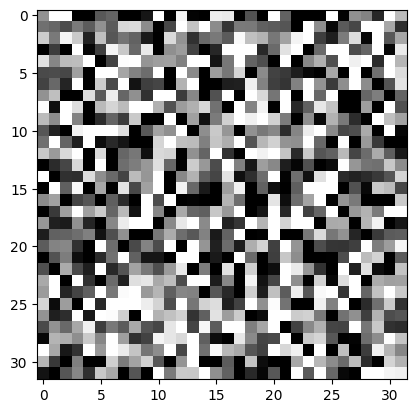

In [35]:
import torch
import torchvision
print(input)

image = torchvision.utils.make_grid(input)
imshow(image)